Generate rooftop dataset from Inira aerial imagery terms of Json formatted GT data for polygonRNN format

### Inira datset

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
image = cv2.imread('./data/AerialImageDataset/train/gt/austin18.tif')

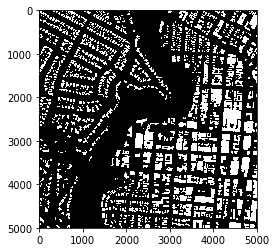

In [3]:
plt.imshow(image)
plt.show()

### Detecting boundary corners of each individual building

In [4]:
img = image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#find Harris corners
gray = np.float32(gray)

dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
ret, dst = cv2.threshold(dst,0.1*dst.max(),255,0)
dst = np.uint8(dst)

#find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

#define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
#here u can get corners
print (corners)

#Now draw them
# res = np.hstack((centroids,corners)) 
# res = np.int0(res) 
# img[res[:,1],res[:,0]]=[0,0,255] 
# img[res[:,3],res[:,2]] = [0,255,0]
# cv2.imwrite('1.png',img)

[[ 2.4991877e+03  2.5010774e+03]
 [ 2.6267987e+02 -6.3512586e-03]
 [ 3.2556223e+02  1.0851650e+00]
 ...
 [ 4.0954417e+03  4.9985586e+03]
 [ 4.7583750e+03  4.9939673e+03]
 [ 4.7583750e+03  4.9939673e+03]]


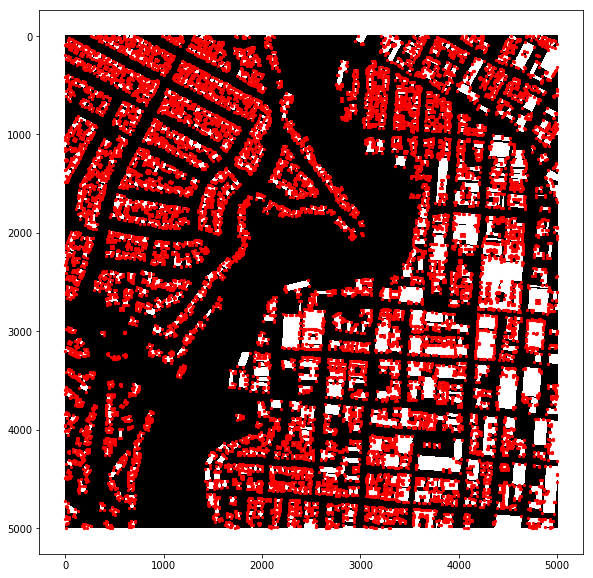

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.scatter(corners[1:,0],corners[1:,1], c = 'r', s = 5)
plt.savefig('./processed.png')

# Instance segmentation using contour plots.

In [6]:
image = cv2.imread('./data/AerialImageDataset/train/gt/austin10.tif')
img = np.copy(image[4500:5000,0:500]) #Image matrix

In [7]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #Convert any colors to B/W

#find contour levels.
ret, thresh = cv2.threshold(gray, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_TC89_KCOS)
output = 5
contours2 = cv2.approxPolyDP(contours[2], 2, True)

In [8]:
#print(contours2)

[[[342 423]]

 [[333 433]]

 [[333 443]]

 [[329 450]]

 [[343 458]]

 [[341 461]]

 [[362 473]]

 [[371 456]]

 [[366 449]]

 [[370 447]]

 [[377 451]]

 [[382 441]]]


In [10]:
#print(hierarchy[0])

In [11]:
print(img[0:1000,400:600].shape)

(500, 100, 3)


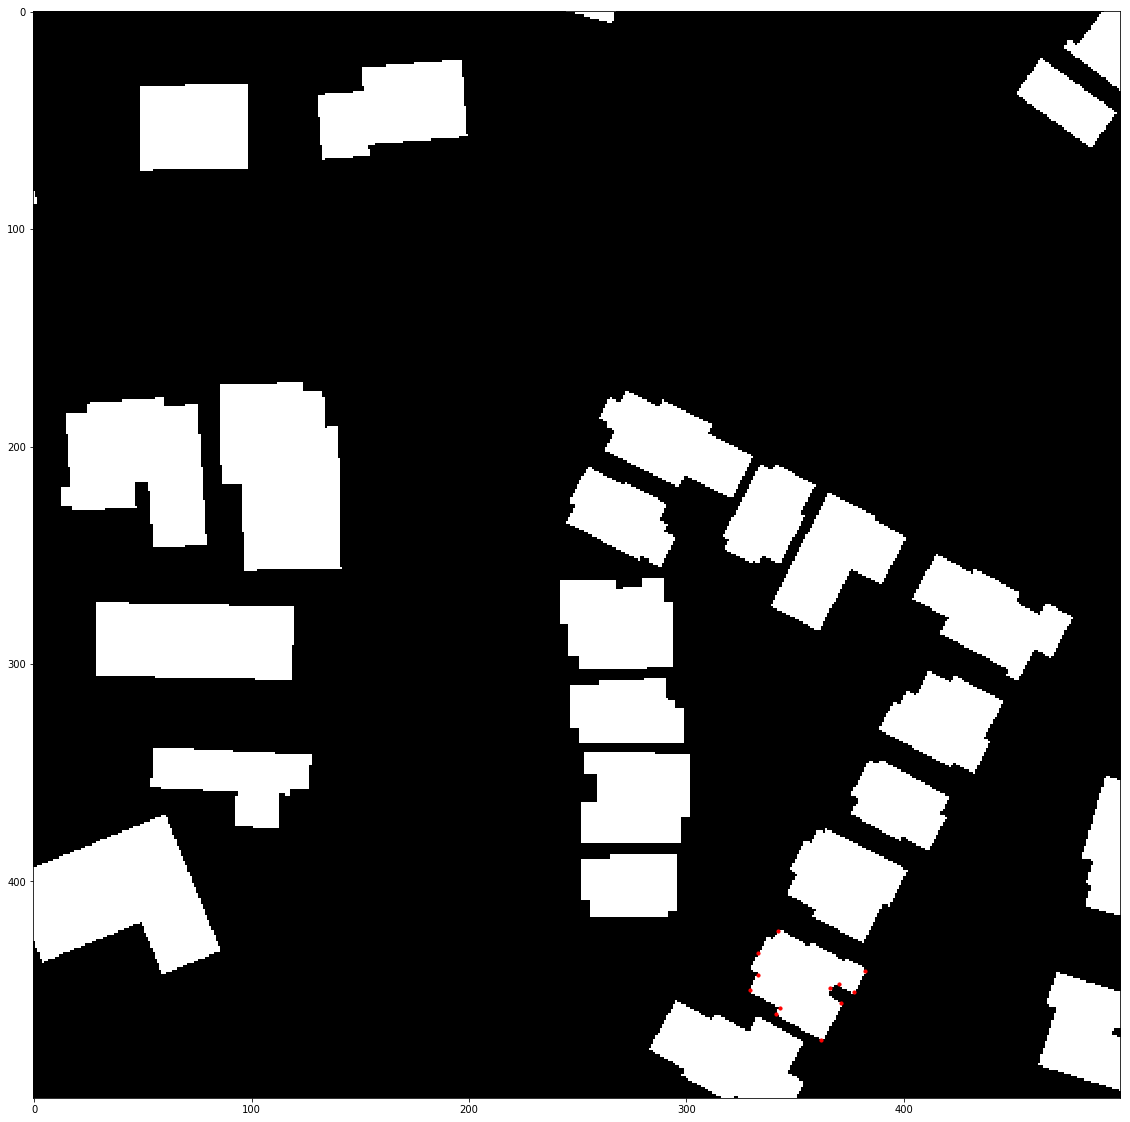

In [12]:
plt.figure(figsize=(20,20))
plt.imshow(img)
for plot in contours2:
    plt.scatter(plot[0][0], plot[0][1], c='r', s=10)
# plt.scatter(corners[1:,0],corners[1:,1], c = 'r', s = 5)
plt.savefig('./processed.png')

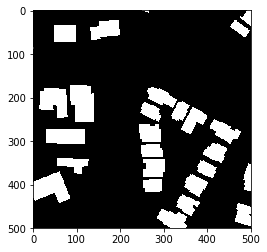

In [13]:
plt.imshow(img,cmap='gray')

# Selecting individual buildings from the mask. 

In [14]:
#Given the city mask, the below code segments the dataset to individual buildings
#It also detects edge corners and produces a outline of the building
#Each building is also displayed from the original satelite image

In [15]:
#Hyperparameters
train_images = ['austin7.tif','austin8.tif','austin9.tif','austin10.tif','austin11.tif','austin12.tif','austin13.tif','austin14.tif','austin15.tif','austin16.tif']
train_val_images = ['austin17.tif']
val_images = ['austin18','austin19.tif']
gt_path = './data/AerialImageDataset/train/gt/'
sat_path = './data/AerialImageDataset/train/images/'



In [45]:
class SatImage:
    #Loads the image and process corners
    def __init__(self, gtImg, satImg):
        self.gtImage = cv2.imread(gtImg)
        self.satImage = cv2.imread(satImg)
        
        assert self.satImage.shape[0] == self.gtImage.shape[0]
        assert self.gtImage.shape[0] == self.gtImage.shape[0]
        
        self.xdim = self.satImage.shape[0]
        self.ydim = self.satImage.shape[1]
        
        self.buildingCorners = self.__detectCorners(self.gtImage)
        self.generateDataBuilding(self.buildingCorners[200], 20, "none",True)
        
        
    #Show the original image
    def showOriginals(self):
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(self.gtImage)
        axarr[1].imshow(self.satImage)
    
    #Detect all the corners in the mask.
    def __detectCorners(self, gtMask):
        #Corner detection
        gray = cv2.cvtColor(gtMask,cv2.COLOR_BGR2GRAY) #Convert any colors to B/W
        ret, thresh = cv2.threshold(gray, 127, 255, 0) #The threshold of our mask.
        #Threshold of detection. RETR_EXTERNAL = Use only outer layer. Chaining with TC_KCOS
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_TC89_KCOS)
        
        #Smoothing of each detected object to reduce number of unwanted points
        smoothBuildingContours = []
        for building in contours:
            smoothed = cv2.approxPolyDP(building, 2, True)
            smoothed = smoothed.squeeze() #Reduce dim to x, y.
            smoothBuildingContours.append(smoothed)
        #List of coordinates
        return(smoothBuildingContours)

    #Check if building after cropped out is part of the Satellite image.
    def __checkValid(self,buildingArray, margin):
        max_x = max(buildingArray[:,0])
        max_y = max(buildingArray[:,1])
        min_x = min(buildingArray[:,0])
        min_y = min(buildingArray[:,1])
        if (max_x + margin) > self.xdim or (min_x - margin) < 0 :
            return(False)
        elif (max_y + margin) > self.ydim or (min_y - margin) < 0:
            return(False)
        else:
            return(True)

    #Generate the building dataset.
    def generateDataBuilding(self,buildingArray, margin, identifier, showPlot=False):
        buildingArray = np.copy(buildingArray)

        #Check if this building can be plotted
        if self.__checkValid(buildingArray, margin) == False:
            print("Coordinates not valid")
            print(buildingArray)
            return

        max_x = max(buildingArray[:,0])
        min_x = min(buildingArray[:,0])
        max_y = max(buildingArray[:,1])
        min_y = min(buildingArray[:,1])

        #Reshape the points to correspond to crop offset. 
        for i in range(buildingArray.shape[0]):
            buildingArray[i][0] -= (min_x-margin)
            buildingArray[i][1] -= (min_y-margin)

#         #Save our bounding box coordinates. 
#         #The coordinate order is the correct path to trace the bbox.
#         print('./data/genTrain/'+imageName+'/'+identifier+'.txt')
#         with open('./data/genTrain/'+imageName+'/'+identifier+'.txt','w') as filetowrite:
#             for line in buildingArray:
#                 filetowrite.write(str(line[0])+" "+str(line[1])+"\n")
#             filetowrite.close()

        #Plot figure and our corner points
        fig = plt.figure(figsize=(4,4), frameon=False)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)

        ax.imshow(self.satImage[min_y-margin:max_y+margin,min_x-margin:max_x+margin], origin='lower')
        ax.scatter(buildingArray[:,0], buildingArray[:,1], c='r', s=10)
#         fig.savefig('./data/genTrain/'+imageName+'/'+identifier+'.png');

        #Don't show plot
        if showPlot == False:
            plt.close(fig)

    #     plt.figure(figsize=(4,4))
    #     plt.imshow(image[min_y-margin:max_y+margin,min_x-margin:max_x+margin], origin='lower')
    #     plt.scatter(buildingArray[:,0], buildingArray[:,1], c='r', s=10)
    #     plt.savefig('./data/genTrain/'+imageName+'/'+identifier+'.png');


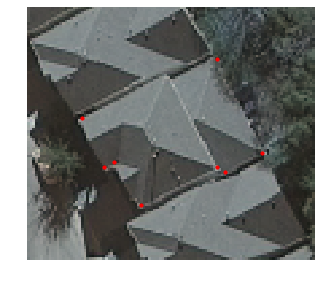

In [46]:
austin7 = SatImage(gt_path+train_images[0],sat_path+train_images[0])

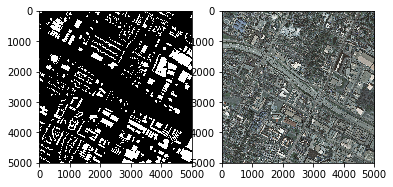

In [117]:
austin7.showOriginals()

In [ ]:
imageName = 'austin15'

In [ ]:
mskImage = cv2.imread('./data/AerialImageDataset/train/gt/'+imageName+'.tif') #These are the ground gt
satImage = cv2.imread('./data/AerialImageDataset/train/images/'+imageName+'.tif') #These are the training images,

In [ ]:
#Image dimensions used when validating.
image_x = mskImage.shape[0]
image_y = mskImage.shape[1]
print(image_x, image_y)